In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm, truncnorm
import corner
import arviz as az
import seaborn as sns
import pymc as pm
import emcee
from scipy.stats import gaussian_kde

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv('../data/gaiadr3_solar_neighborhood.csv')
df

,mg,bp_rp,parallax
0,10.390250,2.731872,10.000008
1,8.608481,2.025819,10.000029
2,4.267759,0.880858,10.000032
3,10.506658,2.649735,10.000066
4,12.077941,2.940875,10.000111
...,...,...,...
227624,11.758283,2.834036,336.026602
227625,9.521769,2.215609,392.752945
227626,14.129570,4.184836,415.179416
227627,11.883816,2.833697,546.975940


In [3]:
nearby_sel = df.parallax > 40.
nearby_df = df[nearby_sel]

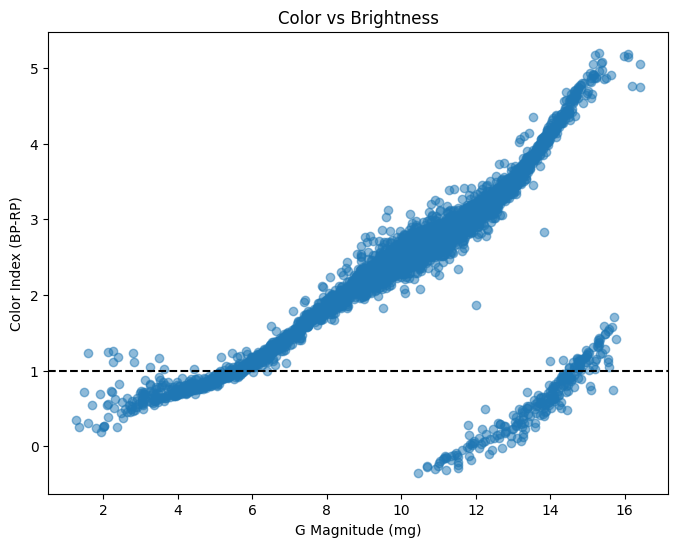

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(nearby_df['mg'], nearby_df['bp_rp'], alpha=0.5)  
plt.xlabel('G Magnitude (mg)')
plt.ylabel('Color Index (BP-RP)')
plt.title('Color vs Brightness')
plt.axhline(y=1, color='black', linestyle='--')
plt.show()

In [5]:
afterExclude_df = nearby_df[(nearby_df['mg'] > 10) & (nearby_df['bp_rp'] > 1)]  
print(afterExclude_df)

               mg     bp_rp    parallax
223559  11.544313  2.992254   40.002314
223560  13.563787  3.794676   40.004848
223561  10.197586  2.492932   40.007115
223562  12.769197  3.373776   40.014745
223563  12.413716  3.135756   40.019696
...           ...       ...         ...
227623  12.881017  3.529414  316.481187
227624  11.758283  2.834036  336.026602
227626  14.129570  4.184836  415.179416
227627  11.883816  2.833697  546.975940
227628  13.411743  3.804580  768.066539

[2214 rows x 3 columns]


In [6]:
print(afterExclude_df['bp_rp'])

223559    2.992254
223560    3.794676
223561    2.492932
223562    3.373776
223563    3.135756
            ...   
227623    3.529414
227624    2.834036
227626    4.184836
227627    2.833697
227628    3.804580
Name: bp_rp, Length: 2214, dtype: float64


In [7]:
print(afterExclude_df['mg'])

223559    11.544313
223560    13.563787
223561    10.197586
223562    12.769197
223563    12.413716
            ...    
227623    12.881017
227624    11.758283
227626    14.129570
227627    11.883816
227628    13.411743
Name: mg, Length: 2214, dtype: float64


In [8]:
def build_model(m, b):
    def model(x):
        return m * x + b
    return model

def lnlikelihood(m, b, sigma_MG, x=afterExclude_df['bp_rp'], y=afterExclude_df['mg']):
    N = x.size
    model = build_model(m, b)
    lnlike = -.5*N*(np.log(2*np.pi*sigma_MG**2)) - (1/(2*sigma_MG**2))*np.sum((y - model(x))**2)
    if sigma_MG < 0:
        lnlike = -np.inf
    return lnlike

In [9]:
initial_m = 2
initial_b = 100
initial_sigma_MG = 5

m = initial_m
b = initial_b
sigma_MG = initial_sigma_MG

p_current = lnlikelihood(m, b, x=afterExclude_df['bp_rp'], y=afterExclude_df['mg'], sigma_MG=sigma_MG)

chain_m = [m]
chain_b = [b]
chain_sigma_MG = [sigma_MG]
probs = [p_current]

In [10]:
niter = 100000

for i in range(niter):
    m_proposed = norm.rvs(loc=m, scale=1)  
    b_proposed = norm.rvs(loc=b, scale=1)  
    sigma_MG_proposed = norm.rvs(loc=sigma_MG, scale=0.01)

    mjump = lnlikelihood(m_proposed, b, x=afterExclude_df['bp_rp'], y=afterExclude_df['mg'], sigma_MG=sigma_MG)
    bjump = lnlikelihood(m, b_proposed, x=afterExclude_df['bp_rp'], y=afterExclude_df['mg'], sigma_MG = sigma_MG)
    sigma_MGjump = lnlikelihood(m, b, x=afterExclude_df['bp_rp'], y=afterExclude_df['mg'], sigma_MG=sigma_MG_proposed)

    
    u = np.random.uniform()

    α = np.exp(mjump - p_current)
    m_accepted = u < α 
    α = np.exp(bjump - p_current)
    b_accepted = u < α
    α = np.exp(sigma_MGjump - p_current)
    sigma_MG_accepted = u < α
    
    if m_accepted.all():
        m = m_proposed 
    if b_accepted.all():
        b = b_proposed
    if sigma_MG_accepted.all():
        sigma_MG = sigma_MG_proposed

    chain_m = np.append(chain_m, m)
    chain_b = np.append(chain_b, b)
    chain_sigma_MG=np.append(chain_sigma_MG, sigma_MG)
    probs = np.append(probs, p_current)  

    

chain_m = np.array(chain_m)
chain_b = np.array(chain_b)
chain_sigma_MG = np.array(chain_sigma_MG) 
probs = np.array(probs)

C:\Users\rabin\AppData\Local\Temp\ipykernel_15556\60300006.py:17: RuntimeWarning: overflow encountered in exp
  α = np.exp(bjump - p_current)
C:\Users\rabin\AppData\Local\Temp\ipykernel_15556\60300006.py:19: RuntimeWarning: overflow encountered in exp
  α = np.exp(sigma_MGjump - p_current)
C:\Users\rabin\AppData\Local\Temp\ipykernel_15556\60300006.py:15: RuntimeWarning: overflow encountered in exp
  α = np.exp(mjump - p_current)


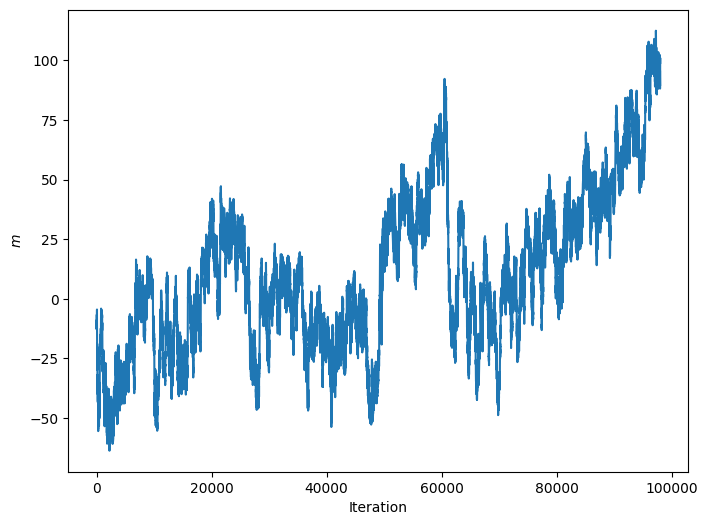

In [11]:
burnin_length = 2000

plt.figure(figsize=(8, 6))
plt.plot(chain_m[burnin_length:])
plt.xlabel('Iteration')
plt.ylabel('$m$')
plt.show()

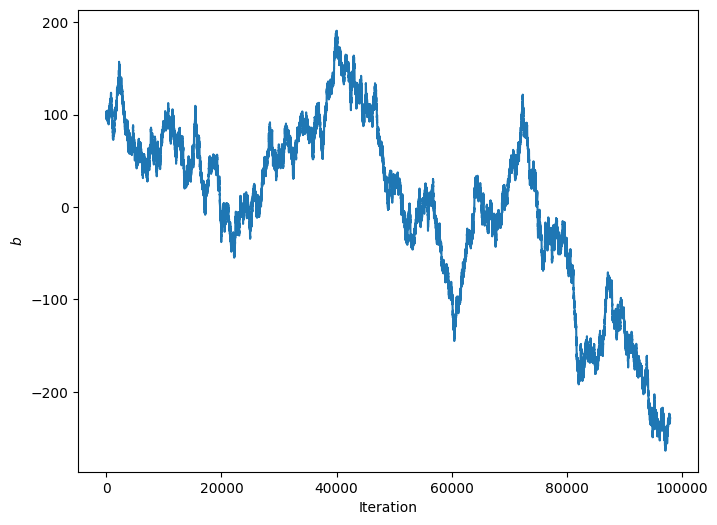

In [12]:
burnin_length = 2000

plt.figure(figsize=(8, 6))
plt.plot(chain_b[burnin_length:])
plt.xlabel('Iteration')
plt.ylabel('$b$')
plt.show()

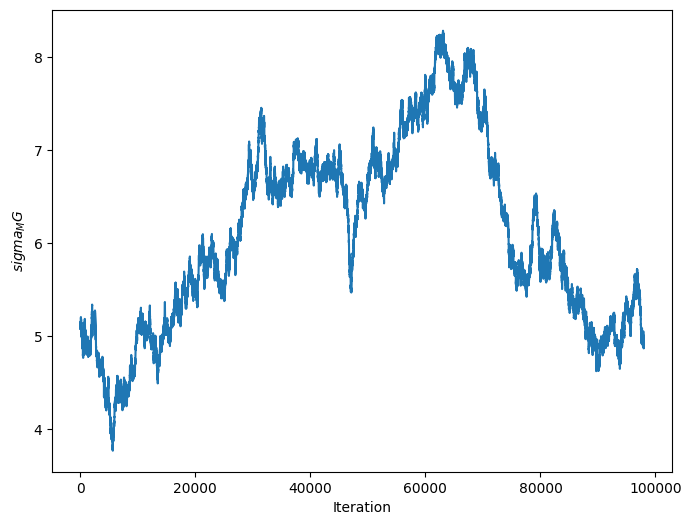

In [13]:
burnin_length = 2000

plt.figure(figsize=(8, 6))
plt.plot(chain_sigma_MG[burnin_length:])
plt.xlabel('Iteration')
plt.ylabel('$sigma_MG$')
plt.show()

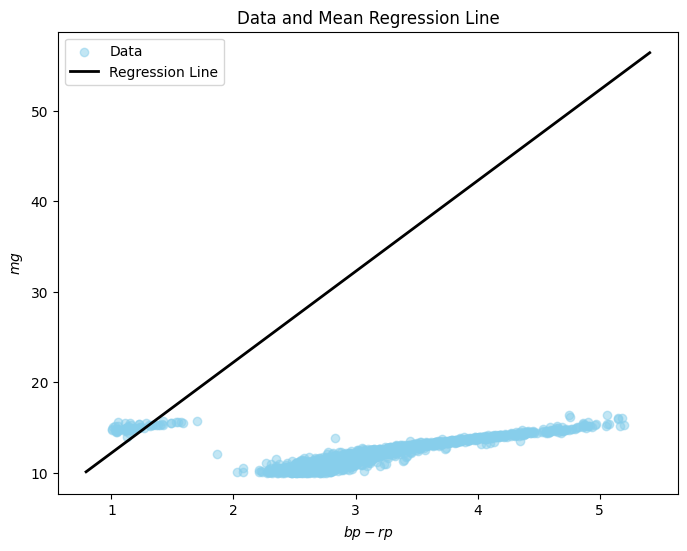

In [14]:
m_mean = np.mean(chain_m)
b_mean = np.mean(chain_b)

x = afterExclude_df['bp_rp']
y = afterExclude_df['mg']

plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='skyblue', label='Data', alpha=0.5)

xlow, xhigh = plt.xlim()
test_x = np.linspace(xlow, xhigh, 100)

model = lambda x: m_mean * x + b_mean  
predictions = model(test_x)

plt.plot(test_x, predictions, color='black', label='Regression Line', linewidth=2)
plt.xlabel('$bp - rp$')
plt.ylabel('$mg$')
plt.title('Data and Mean Regression Line')
plt.legend()
plt.show()


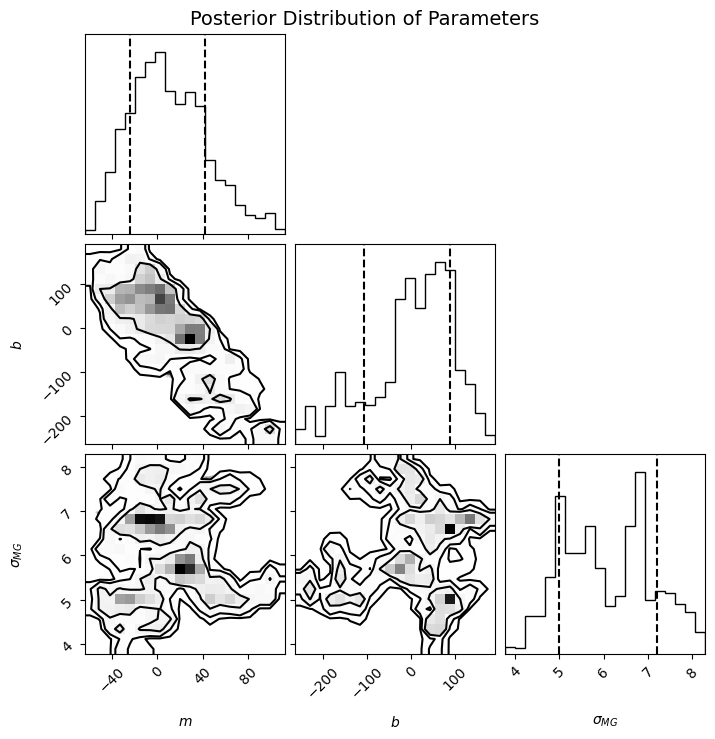

In [15]:
data = np.array([chain_m, chain_b, chain_sigma_MG]).T
labels = ['$m$', '$b$', r'$\sigma_{MG}$']

fig = corner.corner(data, labels=labels, quantiles=(0.16, 0.84), 
                    levels=(0.68, 0.95, 0.997))


fig.suptitle("Posterior Distribution of Parameters", fontsize=14)


plt.show()


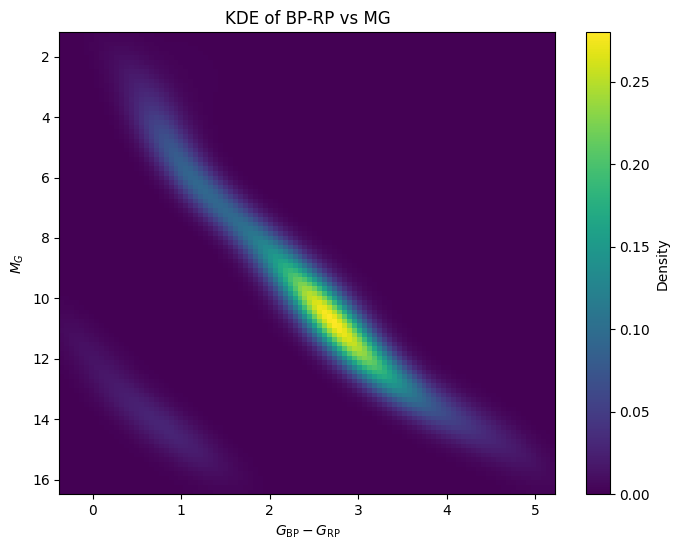

In [16]:
kde = gaussian_kde(np.vstack([nearby_df['bp_rp'], nearby_df['mg']]))
ngrid = 100

xlim = [nearby_df['bp_rp'].min(), nearby_df['bp_rp'].max()]
ylim = [nearby_df['mg'].min(), nearby_df['mg'].max()]

x = np.linspace(*xlim, ngrid)
y = np.linspace(*ylim, ngrid)
X, Y = np.meshgrid(x, y)


Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, Z, shading='auto')
plt.gca().invert_yaxis()  
plt.colorbar(label='Density')  
plt.xlabel(r"${G_\mathrm{BP} - G_\mathrm{RP}}$")
plt.ylabel(r"$M_G$")
plt.title('KDE of BP-RP vs MG')
plt.show()


 I've spent more than 20 hours on this assignment, and I've come to the conclusion that it's really difficult to find a good model. My first homework question revealed a model that fit the facts. However, I could not show for this assignment. The model appears to match lower values but not high ones.